In [88]:
import warnings
warnings.filterwarnings('ignore')

In [111]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn import linear_model, tree, metrics
from sklearn.metrics import make_scorer, accuracy_score, confusion_matrix, classification_report, roc_curve, auc

# 1. Data Quality Check

In [124]:
data = pd.read_csv('conversion_project.csv')
data.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


In [125]:
data.country.value_counts()

US         178092
China       76602
UK          48450
Germany     13056
Name: country, dtype: int64

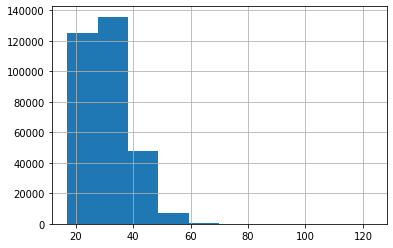

In [126]:
hist = data.age.hist()

In [127]:
data.new_user.value_counts()

1    216744
0     99456
Name: new_user, dtype: int64

In [128]:
data.source.value_counts()

Seo       155040
Ads        88740
Direct     72420
Name: source, dtype: int64

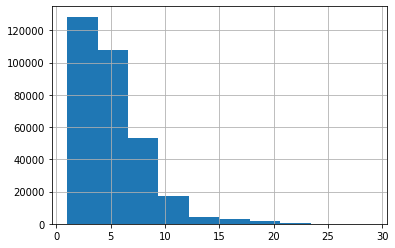

In [129]:
hist = data.total_pages_visited.hist()

In [130]:
data.converted.value_counts()

0    306000
1     10200
Name: converted, dtype: int64

In [131]:
data.describe()

,age,new_user,total_pages_visited,converted
count,316200.000000,316200.000000,316200.000000,316200.000000
mean,30.569858,0.685465,4.872966,0.032258
std,8.271802,0.464331,3.341104,0.176685
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,123.000000,1.000000,29.000000,1.000000


The maximum age in this dataframe is 123, which is unrealistic. Other variables seems reasonable. Lets check variable age. I found there are two records with age 111 and 123, let's delete those 2 rows. 

In [132]:
data.age.value_counts().sort_index()

17      7597
18      8466
19      9349
20     10156
21     10966
22     11701
23     12336
24     12960
25     13460
26     13931
27     14084
28     14341
29     14158
30     14346
31     13692
32     13507
33     12631
34     12108
35     11471
36     10779
37      9761
38      8970
39      8202
40      7148
41      6401
42      5588
43      4904
44      4224
45      3634
46      2994
47      2504
48      2121
49      1629
50      1356
51      1093
52       935
53       627
54       520
55       394
56       286
57       247
58       165
59       127
60        94
61        71
62        59
63        35
64        27
65        15
66         9
67         5
68         5
69         3
70         2
72         1
73         1
77         1
79         1
111        1
123        1
Name: age, dtype: int64

In [133]:
 data = data[data['age']<100]

# 2 EDA

1. Based on the following graph, we can see the average conversion rate in different countries. Germany has the highest conversion rate. But China has the lowest conversion rate, which is only 0.1%, there might be some problem in the Chinese website. 

In [181]:
data[['country', 'converted']].groupby('country').mean()

,converted
country,
China,0.001332
Germany,0.062428
UK,0.052612
US,0.037801


2. Conversion rate of old user is much higher than new user, which make sense. 

In [135]:
data[['new_user', 'converted']].groupby('new_user').mean()

,converted
new_user,
0,0.071983
1,0.014021


3. Conversion rate from different sources is pretty close, around 3%.

In [136]:
data[['source', 'converted']].groupby('source').mean()

,converted
source,
Ads,0.034472
Direct,0.028169
Seo,0.032888


4. lets look at the relationship between age and conversion. After cleaning this datarame, age ranges from 17 to 79, I will manually convert age in to 7 bins. The following data shows the average conversion rate for different age group. Younger people have higher conversion rate, while elder people have lower conversion rate. From the following dot plot, we can also see the negative relationship between age and conversion. 

In [137]:
temp = data[['age', 'converted']]
temp['age'] = temp['age'].apply(lambda x: str(x)[0])
temp.groupby('age').mean()

,converted
age,
1,0.064969
2,0.042680
3,0.022205
4,0.011787
5,0.004870
6,0.009288
7,0.000000


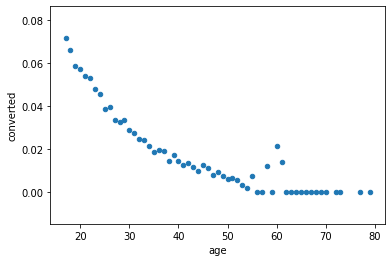

In [138]:
plt_data = data[['age', 'converted']].groupby('age').mean().reset_index()
plt_data.plot.scatter(x='age',
                      y='converted')

5. let's now look at the relationship between total_pages_visited and conversion. The following table and graph shows ss a user visits more pages, there is a higher conversion rate. 

In [139]:
plt_data = data[['total_pages_visited', 'converted']].groupby('total_pages_visited').mean().reset_index()
plt_data

,total_pages_visited,converted
0,1,0.000000
1,2,0.000228
2,3,0.000251
3,4,0.000780
4,5,0.001570
5,6,0.003437
6,7,0.006769
7,8,0.015238
8,9,0.033067
9,10,0.061068


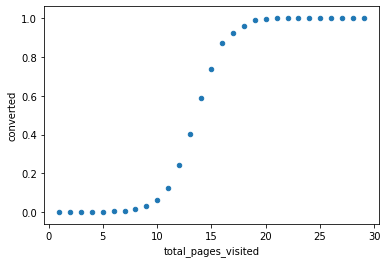

In [140]:
plt_data.plot.scatter(x='total_pages_visited',
                      y='converted')

# 2 Predictive Modeling

## 2.1 Logistic Regression

Logistic regression does not support categorical variable, so I need to do one-hot encoding before fitting the model. 

In [171]:
X = data.iloc[:, :-1]
y = data.iloc[:, -1]
### One hot encoding
enc = OneHotEncoder(handle_unknown='ignore')
data_enc = enc.fit(X.values)
X_enc = enc.fit_transform(X[['country','source']]).toarray()
X = np.concatenate([X[['age','new_user','total_pages_visited']].values, X_enc],axis=1)
### Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

In [142]:
k_fold = StratifiedKFold(n_splits=10)
clf_log = linear_model.LogisticRegression(solver='liblinear')
param_range = [0.01,0.1, 1, 10]
params= {'C': param_range, 'penalty': ['l1','l2']}
scoring_fnc = make_scorer(accuracy_score)
grid = GridSearchCV(clf_log, param_grid=params,scoring=scoring_fnc,cv=k_fold)
grid = grid.fit(X_train, y_train)
clf_log = grid.best_estimator_

print('best score: %f'%grid.best_score_)
# print('best parameters:')
for key in params.keys():
    print('%s: %s'%(key, clf_log.get_params()[key]))
print('test score: %f'%clf_log.score(X_test, y_test))

best score: 0.986156
C: 1
penalty: l1
test score: 0.986448


In [63]:
cm = confusion_matrix(y_test,clf_log.predict(X_test))
# sns.heatmap(cm,annot=True,fmt="d")
print(cm)
print(classification_report(y_test,clf_log.predict(X_test)))

[[60931   262]
 [  676  1371]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     61193
           1       0.84      0.67      0.75      2047

    accuracy                           0.99     63240
   macro avg       0.91      0.83      0.87     63240
weighted avg       0.98      0.99      0.98     63240



In [60]:
print('coef', clf_log.coef_)
print('intercept', clf_log.intercept_)

coef [[-0.07535567 -1.74548311  0.7590769  -4.68434248 -0.82084081 -1.06890346
  -1.43624951 -2.98762089 -3.18096419 -3.00167932]]
intercept [-2.64478156]


Interpretation:

-0.07535567*age -1.74548311*new_user + 0.7590769*total_page_visited -4.68434248*China -0.82084081*Germany -1.06890346*UK
  -1.43624951*US -2.98762089*Ads -3.18096419*Direct -3.00167932*Seo

Age is negatively correlated with conversion.

## 2.2 XGBoost

Since logistic regression does not give me which variable is more important in predicting conversion, now I will try XGBoost, which will give me a list of feature importance.

In [177]:
import xgboost as xgb
X = pd.DataFrame(X, columns=['age','new_user','total_pages_visited','China','Germany','UK','US','Ads','Direct','Seo'])
data_dmatrix = xgb.DMatrix(data=X, label=y)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)
xg_clf = xgb.XGBClassifier()

### defult setting of XGBClassfier: 
# XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
#        gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=10,
#        min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
#        objective='binary:logistic', reg_alpha=0, reg_lambda=1,
#        scale_pos_weight=1, seed=0, silent=True, subsample=1)

params = {'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}
#scoring_fnc = make_scorer(mean_squared_error)
#cv_results = GridSearchCV(xg_reg, param_grid=params,scoring=scoring_fnc,cv=3)
cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50, early_stopping_rounds=10, metrics="error", as_pandas=True, seed=123)

xg_clf = xg_clf.fit(X_train,y_train)
#clf_xg = grid.best_estimator_

In [178]:
cm = confusion_matrix(y_test,xg_clf.predict(X_test))
print(cm)
print(classification_report(y_test,clf_log.predict(X_test)))

[[60934   231]
 [  653  1422]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     61165
           1       0.86      0.70      0.77      2075

    accuracy                           0.99     63240
   macro avg       0.93      0.85      0.88     63240
weighted avg       0.99      0.99      0.99     63240



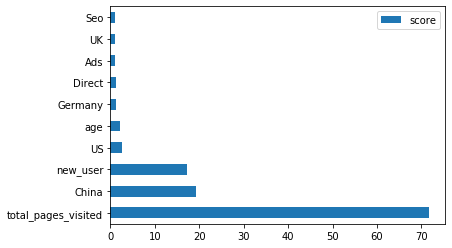

In [179]:
feature_importance = xg_clf.get_booster().get_score(importance_type="gain")
keys = list(feature_importance.keys())
values = list(feature_importance.values())

feature_importance = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
feature_importance.plot(kind='barh')

Based on above graph, total pages visited is the most important feature in predicting conversion, but it is the leat actionable one. Other important features are China(boolean) and new_user. Based on the previous EDA, I have found that the conversion rate in China is much lower than other countries. Based on this information, the company can perform further analysis on chinese uses to detect any possible reasons for the loe conversion rate. 